In [1]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

# import pybullet_envs
import pybullet_envs_gymnasium as pybullet_envs
import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
# import gym
import gymnasium as gym
import io
import os
import gc

from gym import wrappers
from skimage.transform import resize
from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [3]:
torch.cuda.is_available()

True

In [4]:
class TTFGasStorageEnv(gym.Env):
    def __init__(self, params):
        super(TTFGasStorageEnv, self).__init__()
        
        self.max_timesteps = 30 * 12 #Simplistic Case
        self.seed_value = params.get('seed', None)
        self.dt = 1.0 / self.max_timesteps
        # self.storage_capacity = params['storage_capacity']
        self.V_min = params['V_min']
        self.V_max = params['V_max']
        self.V_0 = params['V_0']
        self.I_max = params['I_max']
        self.W_max = params['W_max']
        self.n_months = params['n_months']
        
        ## Yan (2002) Model Parameters
        # Short rate: r_t
        self.initial_r = params['initial_r'] # Initial short rate
        self.theta_r = params['theta_r'] # Long‐run mean level of r_t
        self.kappa_r = params['kappa_r'] # Speed of mean reversion for r_t
        self.sigma_r = params['sigma_r'] # Volatility coefficient (diffusion) for r_t

        # Convenience Yield: delta_t
        self.initial_delta = params['initial_delta'] # Initial convenience yield
        self.theta_delta = params['theta_delta'] # Long‐run mean of delta_t
        self.kappa_delta = params['kappa_delta'] # Speed of mean reversion for delta_t
        self.sigma_delta = params['sigma_delta'] # Volatility coefficient (diffusion) for delta_t

        # Stochastic Variance v_t
        self.initial_v = params['initial_v'] # Initial variance
        self.kappa_v = params['kappa_v'] # Long‐run mean of v_t
        self.sigma_v = params['sigma_v'] # Speed of mean reversion for v_t
        self.theta_v = params['theta_v'] # Volatility coefficient (diffusion) for v_t

        # Spot Price Factor S_t
        self.initial_spot_price = params['initial_spot_price'] # Initial (de‐seasoned) spot price.
        self.sigma_s = params['sigma_s'] # Factor loading” or volatility parameter on S_t

        # Jump Process Parameters
        self.lam = params['lam'] # Jump intensity (Poisson arrival rate)
        self.mu_j = params['mu_j'] # average size of spot‐price jumps
        self.sigma_j = params['sigma_j'] # dispersion (volatility) of spot‐price jumps
        self.theta = params['theta'] # v_t jump size
        
        # Correlations among Brownian increments
        self.rho_1 = params['rho_1'] # Correlation between dW_1 and dW_delta
        self.rho_2 = params['rho_2'] # Correlation between dW_2 and dW_v

        # ksi_r constant in futures formula
        self.ksi_r = np.sqrt(self.kappa_r**2 + 2*self.sigma_r**2)

        ## Penalty parameters
        self.penalty_lambda1 = params['penalty_lambda1']  # For inequality constraint violation
        self.penalty_lambda2 = params['penalty_lambda2']  # For final sum violation
        # self.bonus_lambda = params['bonus_lambda']      # For hitting final sum exactly (optional bonus)

        # Seasonal Factors (Month 1 is April, Month 12 is March)
        # self.seasonal_factors = pd.read_csv('interpolated_seasonal_factors.csv',index_col=0)
        self.seasonal_factors = params['monthly_seasonal_factors']

        # Set the seed for reproducibility
        self.seed(self.seed_value)

        # ----- ACTION SPACE -----
        # Each action is an array of length self.n_months (injection/withdrawal for each month).
        # Box constraints: [-W_max, I_max] for each entry.
        low = np.array([-self.W_max]*(self.n_months), dtype=np.float32)
        high = np.array([ self.I_max]*(self.n_months), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=low, high=high, shape=(self.n_months,), dtype=np.float32, seed=self.seed_value)
        # low = np.array([0.0] + [-self.W_max]*(self.n_months - 2) + [-self.W_max])
        # high = np.array([self.I_max] + [self.I_max]*(self.n_months - 2) + [0.0])
        # self.action_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
        # injection_bounds = [0.0] * 6
        # withdrawal_bounds = [0.0] * 6
        
        # low = np.array(injection_bounds + [-self.W_max] * 6, dtype=np.float32)
        # high = np.array([self.I_max] * 6 + withdrawal_bounds, dtype=np.float32)
        
        # self.action_space = gym.spaces.Box(
        #     low=low,
        #     high=high,
        #     shape=(self.n_months,),
        #     dtype=np.float32,
        #     seed=self.seed_value
        # )

        # ----- OBSERVATION SPACE -----
        # 1) month index t (discrete 1..12) - will store as an integer
        # 2) futures term structure: 12 prices max
        # 3) storage level V_t
        # We'll flatten them into one array for Gym:
        # Structure: [month (1), futures prices (12), storage level (1)] → Total = 14 elements
        self.observation_space = gym.spaces.Box(
            low=np.concatenate(([0], [-np.inf] * 12, [self.V_min])),  # Lower bounds
            high=np.concatenate(([12], [np.inf] * 12, [self.V_max])),  # Upper bounds
            shape=(14,), dtype=np.float32, seed=self.seed_value
        )
        
        # Initialize environment variables
        self.reset()
    
    def seed(self, seed=None):
        """
        Seed the environment, ensuring reproducibility of the randomness in the environment.
        """
        if seed is not None:
            self.seed_value = seed  # Update seed if provided
        self.W = np.random.default_rng(seed=self.seed_value)  # Seed the random generator
        #self.action_space.seed(self.seed_value)  # Seed the action space random generator
        return [self.seed_value]   

    def compute_futures_curve(self):
        """
        Computes the futures curve at the current day t, ensuring:
        - The length of the futures curve is always 12.
        - Expired futures are replaced with 0.0.
        - Futures prices are determined using the Yan (2002) model.
    
        Returns:
          np.ndarray : Array of 12 futures prices (valid prices or 0.0 for expired contracts).
        """
        futures_list = np.full(12, 0.0, dtype=np.float32)  # Initialize all values as 0.0
    
        # Determine the number of remaining valid futures contracts
        remaining_futures = max(12 - (self.day // 30), 0)  # Shrinks every 30 days
    
        for k in range(12):
            expiration_day = (k+1) * 30  # Expiration at the end of month (1-based index)
    
            # Compute time to expiration tau in years
            tau = (expiration_day - self.day) / 360.0
    
            if tau < 0:  # Contract expired, skip (remains 0.0)
                continue
    
            # Compute beta functions using Yan (2002) model
            beta_r = (2 * (1 - np.exp(-self.ksi_r * tau))) / (2 * self.ksi_r - (self.ksi_r - self.kappa_r) * (1 - np.exp(-self.ksi_r * tau)))
            beta_delta = -(1 - np.exp(-self.kappa_delta * tau)) / self.kappa_delta
            beta_0 = (self.theta_r / self.sigma_r**2) * (2 * np.log(1 - (self.ksi_r - self.kappa_r) * (1 - np.exp(-self.ksi_r * tau)) / (2 * self.ksi_r))
                                                         + (self.ksi_r - self.kappa_r) * tau) \
                     + (self.sigma_delta**2 * tau) / (2 * self.kappa_delta**2) \
                     - (self.sigma_s * self.sigma_delta * self.rho_1 + self.theta_delta) * tau / self.kappa_delta \
                     - (self.sigma_s * self.sigma_delta * self.rho_1 + self.theta_delta) * np.exp(-self.kappa_delta * tau) / self.kappa_delta**2 \
                     + (4 * self.sigma_delta**2 * np.exp(-self.kappa_delta * tau) - self.sigma_delta**2 * np.exp(-2 * self.kappa_delta * tau)) / (4 * self.kappa_delta**3) \
                     + (self.sigma_s * self.sigma_delta * self.rho_1 + self.theta_delta) / self.kappa_delta**2 \
                     - 3 * self.sigma_delta**2 / (4 * self.kappa_delta**3)
    
            # Compute the forward price F_tk
            F_tk = np.exp(np.log(self.S_t) + self.seasonal_factors[k] + beta_0 + beta_r * self.r_t + beta_delta * self.delta_t)
    
            # Store the computed futures price
            futures_list[k] = F_tk
    
        return futures_list

    def reset(self):
        self.month = 0
        self.day = 0
        
        self.S_t = self.initial_spot_price
        self.r_t = self.initial_r
        self.delta_t = self.initial_delta
        self.v_t = self.initial_v
        self.F_t = self.compute_futures_curve() 
        
        self.S_trajectory = [self.S_t]
        self.r_trajectory = [self.r_t]
        self.delta_trajectory = [self.delta_t]
        self.v_trajectory = [self.v_t]
        self.F_trajectory = [self.F_t]
        
        self.V_t = self.V_0
        
        return np.concatenate(([self.month], self.F_t, [self.V_t]), dtype=np.float32), {}

    def step(self, action):
        
        # Validate action dimension
        assert len(action) == self.n_months, "Action must have length = n_months"
        
        # last_action = -self.V_t - action.cumsum()[-1]
        # action = np.concatenate((action, np.array([last_action], dtype=np.float32)))
        
        is_terminal = False
        is_truncated = False
        
        # # ---- APPLY ACTION AND CHECK CONSTRAINTS ----
        # running_sum = 0.0
        # for i in range(max(self.month - 1, 0), self.n_months): # Ensure valid range
        #     # Step 1 (τ_1): Full vector X_0 = [X_0^1, ..., X_0^12]
        #     if self.month == 0:
        #         running_sum += action[i]
        #         new_volume = self.V_t + running_sum  # Here self.V_t == self.V_0
        #     else:
        #         running_sum += action[i]
        #         new_volume = self.V_t + running_sum  # Update storage


        #     # ---- HARD REJECT: Cumulative constraint violation ----
        #     if new_volume < self.V_min or new_volume > self.V_max:
        #         self.CF -= 10#1_000_000.0  # Huge negative penalty
        #         is_truncated = True
        #         return np.concatenate(([self.month+1], self.F_t, [self.V_t]), dtype=np.float32), self.CF, is_terminal, is_truncated, {}
        #     # Except for the first loop, updating V_t: V_t = V_{t-1} + X_{t}^t   
        #     if self.month != 0 and i == max(self.month - 1, 0):
        #         self.V_t = new_volume
        #         running_sum = 0

        # ---- APPLY ACTION AND CHECK CONSTRAINTS ----
        running_sum = 0.0
        cost1 = 0.0
        cost2 = 0.0
        reward = 0.0
        for i in range(max(self.month - 1, 0), self.n_months): # Ensure valid range
            running_sum += action[i]
            new_volume = self.V_t + running_sum  # Update storage

            # ---- SOFT REJECT: Cumulative constraint violation ----
            if new_volume + 0.001 < self.V_min or new_volume - 0.001 > self.V_max:
                # print("new_volume: ",new_volume)
                # print("min(new_volume - self.V_min, self.V_max - new_volume): ",min(new_volume - self.V_min, self.V_max - new_volume))
                cost1 += min(new_volume - self.V_min, self.V_max - new_volume) * self.penalty_lambda1
            # Except for the first loop, updating V_t: V_t = V_{t-1} + X_{t}^t   
            if self.month != 0 and i == max(self.month - 1, 0):
                self.V_t = np.clip(new_volume, self.V_min, self.V_max)
                running_sum = 0
        # Computing the 12th action (dependent action) and adding penalties for the last dependent action decision
        # last_action = np.clip(-self.V_t, -self.W_max, self.I_max)
        
        whole_volume = new_volume

        # ---- FINAL STORAGE BALANCE CONSTRAINT (SOFT PENALTY) ----
        # if abs(self.V_t + last_action) > 0.005: # If balance is not exactly zero
        if abs(whole_volume) > 0.001: # If balance is not exactly zero
            # print('cost2', whole_volume)
            # cost2 += -abs(self.V_t + last_action) * self.penalty_lambda2  # Soft penalty
            cost2 += -abs(whole_volume) * self.penalty_lambda2  # Soft penalty
            
        reward += cost1
        reward += cost2
        # if abs(total_balance) > 1e-7:  # If balance is not exactly zero
            # cost2 = -abs(total_balance) * self.penalty_lambda2  # Soft penalty
            # reward += cost2  # Apply penalty to cumulative cost
                    

        # # Update storage level:
        # if self.month != 0:
            
        #     chosen_action = action[self.month - 1]
            
        #     # Update storage volume
        #     old_V_t = self.V_t
        #     self.V_t += chosen_action
        #     #self.CF_S += - self.F_t[self.month -1] * action[self.month - 1] #This is the spot cash-flow from gas purchases or sales

        # Store state at time t
        month = self.month
        F_t = self.F_t
        V_t = self.V_t

        for i in range(30):
            # Generate independent Brownian increments
            dW_1 = self.W.normal(0, np.sqrt(self.dt))  # For dW_1
            dW_r = self.W.normal(0, np.sqrt(self.dt))  # For dW_r (interest rate)
            dW_2 = self.W.normal(0, np.sqrt(self.dt))  # For dW_2
            dW_delta = self.rho_1 * dW_1 + np.sqrt(1 - self.rho_1 ** 2) * self.W.normal(0, np.sqrt(self.dt))  # For dW_delta (correlated with dW_1)
            dW_v = self.rho_2 * dW_2 + np.sqrt(1 - self.rho_2 ** 2) * self.W.normal(0, np.sqrt(self.dt))  # For dW_v (correlated with dW_2)
            
            # Probability of jump occurrence
            dq = self.W.choice([0, 1], p=[1 - self.lam * self.dt, self.lam * self.dt])
    
            # Jump magnitude: ln(1 + J) ~ N[ln(1 + mu_J) - 0.5 * sigma_J^2, sigma_J^2]
            ln_1_plus_J = self.W.normal(np.log(1 + self.mu_j) - 0.5 * self.sigma_j ** 2, self.sigma_j)
            J = np.exp(ln_1_plus_J) - 1  # Jump size for the spot price

            J_v = self.W.exponential(scale=self.theta)
    
            # Stochastic differential equations (SDEs)
            # dS_t = (r_t - delta_t - \lambda \mu_J)S_t dt + \sigma_s S_t dW_1 + \sqrt{V_t} S_t dW_2 + J S_t dq
            dS_t = (self.r_t - self.delta_t - self.lam * self.mu_j) * self.S_t * self.dt + self.sigma_s * self.S_t * dW_1 + np.sqrt(max(self.v_t,0)) * self.S_t * dW_2 + J * self.S_t * dq
            self.S_t += dS_t
            self.S_trajectory.append(self.S_t)
            
            # dr_t = (\theta_r - \kappa_r r_t) dt + \sigma_r \sqrt{r_t} dW_r
            dr_t = (self.theta_r - self.kappa_r * self.r_t) * self.dt + self.sigma_r * np.sqrt(max(self.r_t, 0)) * dW_r
            self.r_t += dr_t
            self.r_trajectory.append(self.r_t)
    
            # ddelta_t = (\theta_delta - \kappa_delta \delta_t) dt + \sigma_delta dW_delta
            ddelta_t = (self.theta_delta - self.kappa_delta * self.delta_t) * self.dt + self.sigma_delta * dW_delta
            self.delta_t += ddelta_t
            self.delta_trajectory.append(self.delta_t)
    
            # dv_t = (\theta_v - \kappa_v v_t) dt + \sigma_v \sqrt{v_t} dW_v + J_v dq
            dv_t = (self.theta_v - self.kappa_v * self.v_t) * self.dt + self.sigma_v * np.sqrt(max(self.v_t, 0)) * dW_v + J_v * dq
            self.v_t += dv_t
            self.v_trajectory.append(self.v_t)  

            self.day += 1
            self.F_t = self.compute_futures_curve() 
            self.F_trajectory.append(self.F_t)
        self.month += 1
        reward += np.dot((self.F_t - F_t), action)
        # self.CF = self.CF_S + self.CF_F
        # Check termination condition
        is_terminal = False
        is_truncated = False
        if self.month == 12: 
            is_terminal = True
            # last_action = np.clip(-self.V_t, -self.W_max, self.I_max)
            reward += - self.F_t[-1] * action[-1]
            # reward += - self.F_t[-1] * last_action
            # self.V_t += last_action
            self.V_t += action[-1]
            self.V_t = np.clip(self.V_t, self.V_min, self.V_max)
            # new_volume = self.V_t + last_action  # Update storage
            # if new_volume + 1e-7 < self.V_min or new_volume - 1e-7 > self.V_max:
            #     cost1 += min(new_volume - self.V_min, self.V_max - new_volume) * self.penalty_lambda1
            #     reward += cost1
            # self.V_t = new_volume
            # if abs(self.V_t) > 1e-7:  # If balance is not exactly zero
            #     cost2 = -abs(self.V_t) * self.penalty_lambda2  # Soft penalty
            #     reward += cost2  # Apply penalty to cumulative cost
            # self.month += 1
            # self.F_t = np.full(12, 0.0, dtype=np.float32)
            # return np.concatenate(([self.month], self.F_t, [self.V_t]), dtype=np.float32), reward, is_terminal, is_truncated, info
        info = {'cost1':cost1, 'cost2':cost2}
        return np.concatenate(([self.month], self.F_t, [self.V_t]), dtype=np.float32), reward, is_terminal, is_truncated, info

In [5]:
class ReplayBuffer():
    def __init__(self, 
                 max_size=100000,
                 batch_size=128):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

In [6]:
class FCQSA(nn.Module):
    def __init__(self,
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQSA, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    # def load(self, experiences):
    #     states, actions, new_states, rewards, is_terminals = experiences
    #     states = torch.from_numpy(states).float().to(self.device)
    #     actions = torch.from_numpy(actions).float().to(self.device)
    #     new_states = torch.from_numpy(new_states).float().to(self.device)
    #     rewards = torch.from_numpy(rewards).float().to(self.device)
    #     is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    #     return states, actions, new_states, rewards, is_terminals
    def load(self, experiences):
        states, actions, rewards, new_states, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, rewards, new_states, is_terminals

In [7]:
class FCGP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 action_bounds,
                 log_std_min=-20, 
                 log_std_max=2,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu,
                 entropy_lr=0.001):
        super(FCGP, self).__init__()
        self.activation_fc = activation_fc
        self.env_min, self.env_max = action_bounds
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
        self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device, 
                                    dtype=torch.float32)
        
        # self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
        # self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
        # self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
        #                             (self.nn_max - self.nn_min) + self.env_min
    
        self.target_entropy = -np.prod(self.env_max.shape)
        self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)

    def _get_futures_mask(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device, dtype=torch.float32)
        if state.ndim == 1:
            state = state.unsqueeze(0)
    
        month = int(state[0, 0].item())
        num_expired = max(0, month - 1)
    
        mask = np.ones(self.env_max.shape[0], dtype=np.float32)
        mask[:num_expired] = 0.0
        return mask

    def _apply_action_mask(self, mean, log_std, state):
        """
        Zero out mean and log_std for expired futures contracts based on the current month
        extracted from the state (state[:, 0]).
    
        Args:
            mean (Tensor): shape (batch_size, action_dim)
            log_std (Tensor): shape (batch_size, action_dim)
            state (Tensor): shape (batch_size, obs_dim)
    
        Returns:
            mean_masked, log_std_masked: same shape, with expired futures zeroed out
        """
        # Extract current month from the first feature of the state
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device, dtype=torch.float32)
        if state.ndim == 1:
            state = state.unsqueeze(0)  # Add batch dimension
    
        batch_size = state.size(0)
        months = state[:, 0].long().clamp(min=0, max=11)  # Ensure valid index range
    
        # Create mask: 1 for active futures, 0 for expired
        # Shape: (batch_size, action_dim)
        mask = torch.ones((batch_size, self.env_max.shape[0]), device=self.device)
        for i in range(batch_size):
            num_expired = max(0, months[i].item() - 1)
            mask[i, :num_expired] = 0.0
    
        # Apply mask: zero mean and set log_std to low value for zero-variance
        mean = mean * mask
        log_std = log_std * mask + (1 - mask) * self.log_std_min
    
        return mean, log_std

    def compute_dynamic_target_entropy(self, state):
        """
        Dynamically computes target entropy as -1 * number of active futures per state.
        Returns a tensor of shape [batch_size].
        """
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device, dtype=torch.float32)
        if state.ndim == 1:
            state = state.unsqueeze(0)
    
        # Get mask using existing method
        batch_size = state.size(0)
        months = state[:, 0].long().clamp(min=0, max=11)
        mask = torch.ones((batch_size, self.env_max.shape[0]), device=self.device)
        for i in range(batch_size):
            num_expired = max(0, months[i].item() - 1)
            mask[i, :num_expired] = 0.0
    
        # Number of active dimensions per sample
        num_active_dims = mask.sum(dim=1)
        return -num_active_dims  # shape: [batch_size]
    
    def rescale_fn(self, x):
        return (x + 1) * (self.env_max - self.env_min) / 2 + self.env_min
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x_mean = self.output_layer_mean(x)
        x_log_std = self.output_layer_log_std(x)
        x_log_std = torch.clamp(x_log_std, 
                                self.log_std_min, 
                                self.log_std_max)
        return x_mean, x_log_std

    # def full_pass(self, state, epsilon=1e-6):
    #     mean, log_std = self.forward(state)

    #     pi_s = Normal(mean, log_std.exp())
    #     pre_tanh_action = pi_s.rsample()
    #     tanh_action = torch.tanh(pre_tanh_action)
    #     action = self.rescale_fn(tanh_action)

    #     log_prob = pi_s.log_prob(pre_tanh_action) - torch.log(
    #         (1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
    #     log_prob = log_prob.sum(dim=1, keepdim=True)

    #     return action, log_prob, self.rescale_fn(torch.tanh(mean))

    # def full_pass(self, state, epsilon=1e-6):
    def full_pass(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)

        # Apply expired futures mask
        mean, log_std = self._apply_action_mask(mean, log_std, state)
        
        std = torch.exp(log_std)
    
        # Create normal distribution and sample
        pi_distribution = Normal(mean, std)
        pre_tanh_action = pi_distribution.rsample()
        tanh_action = torch.tanh(pre_tanh_action)
        action = self.rescale_fn(tanh_action)
    
        # Log prob calculation (cleaned)
        log_prob = pi_distribution.log_prob(pre_tanh_action)
        log_prob -= torch.log((1 - tanh_action.pow(2)).clamp(min=epsilon))
        log_prob = log_prob.sum(dim=-1, keepdim=True)
    
        # Return sampled action, log_prob, and greedy action estimate
        greedy_action = self.rescale_fn(torch.tanh(mean))
        return action, log_prob, greedy_action

    def _update_exploration_ratio(self, greedy_action, action_taken):
        env_min, env_max = self.env_min.cpu().numpy(), self.env_max.cpu().numpy()
        self.exploration_ratio = np.mean(abs((greedy_action - action_taken)/(env_max - env_min)))

    def _get_actions(self, state):
        mean, log_std = self.forward(state)

        # Apply action mask to zero-out expired futures
        mean, log_std = self._apply_action_mask(mean, log_std, state)

        action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
        greedy_action = self.rescale_fn(torch.tanh(mean))
        random_action = np.random.uniform(low=self.env_min.cpu().numpy(),
                                          high=self.env_max.cpu().numpy())
        
        # Get the expired futures mask from state and apply to random_action
        mask = self._get_futures_mask(state).reshape(-1)
        random_action = random_action * mask

        action_shape = self.env_max.cpu().numpy().shape
        action = action.detach().cpu().numpy().reshape(action_shape)
        greedy_action = greedy_action.detach().cpu().numpy().reshape(action_shape)
        random_action = random_action.reshape(action_shape)

        return action, greedy_action, random_action

    def select_random_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, random_action)
        return random_action

    def select_greedy_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, greedy_action)
        return greedy_action

    def select_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, action)
        return action

In [12]:
class SAC():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn,
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr

        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps

        self.tau = tau

    # def optimize_model(self, experiences):
    #     states, actions, rewards, next_states, is_terminals = experiences
    #     batch_size = len(is_terminals)

    #     # policy loss
    #     current_actions, logpi_s, _ = self.policy_model.full_pass(states)

    #     target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
    #     alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

    #     self.policy_model.alpha_optimizer.zero_grad()
    #     alpha_loss.backward()
    #     self.policy_model.alpha_optimizer.step()
    #     alpha = self.policy_model.logalpha.exp()

    #     current_q_sa_a = self.online_value_model_a(states, current_actions)
    #     current_q_sa_b = self.online_value_model_b(states, current_actions)
    #     current_q_sa = torch.min(current_q_sa_a, current_q_sa_b)
    #     policy_loss = (alpha * logpi_s - current_q_sa).mean()

    #     # Q loss
    #     ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
    #     q_spap_a = self.target_value_model_a(next_states, ap)
    #     q_spap_b = self.target_value_model_b(next_states, ap)
    #     q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
    #     target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()

    #     q_sa_a = self.online_value_model_a(states, actions)
    #     q_sa_b = self.online_value_model_b(states, actions)
    #     qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
    #     qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

    #     self.value_optimizer_a.zero_grad()
    #     qa_loss.backward()
    #     torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(), 
    #                                    self.value_max_grad_norm)
    #     self.value_optimizer_a.step()

    #     self.value_optimizer_b.zero_grad()
    #     qb_loss.backward()
    #     torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(),
    #                                    self.value_max_grad_norm)
    #     self.value_optimizer_b.step()

    #     self.policy_optimizer.zero_grad()
    #     # policy_loss.backward()
    #     with torch.autograd.set_detect_anomaly(True):
    #         policy_loss.backward()

    #     torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
    #                                    self.policy_max_grad_norm)        
    #     self.policy_optimizer.step()

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
    
        # Clone states to avoid in-place interference
        states = states.clone().detach().requires_grad_(True)
        next_states = next_states.clone().detach()
    
        # === Policy loss ===
        current_actions, logpi_s, _ = self.policy_model.full_pass(states)
    
        # target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
        # alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()
        dynamic_target_entropy = self.policy_model.compute_dynamic_target_entropy(states)
        target_alpha = (logpi_s.detach().squeeze(-1) + dynamic_target_entropy.detach())
        alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()
        if torch.rand(1).item() < 0.01:  # 1% chance to print
            print("Avg active dims:", -dynamic_target_entropy.mean().item())
    
        self.policy_model.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.policy_model.alpha_optimizer.step()
        alpha = self.policy_model.logalpha.exp()
    
        current_q_sa_a = self.online_value_model_a(states, current_actions)
        current_q_sa_b = self.online_value_model_b(states, current_actions)
        current_q_sa = torch.min(current_q_sa_a, current_q_sa_b).clone()  # <- this clone matters!
        policy_loss = (alpha * logpi_s - current_q_sa).mean()
    
        self.policy_optimizer.zero_grad()
        with torch.autograd.set_detect_anomaly(True):
            policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), self.policy_max_grad_norm)
        self.policy_optimizer.step()
    
        # === Value loss ===
        ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
        q_spap_a = self.target_value_model_a(next_states, ap)
        q_spap_b = self.target_value_model_b(next_states, ap)
        q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
        target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()
    
        q_sa_a = self.online_value_model_a(states.detach(), actions)
        q_sa_b = self.online_value_model_b(states.detach(), actions)
        qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
        qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()
    
        self.value_optimizer_a.zero_grad()
        qa_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(), self.value_max_grad_norm)
        self.value_optimizer_a.step()
    
        self.value_optimizer_b.zero_grad()
        qb_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(), self.value_max_grad_norm)
        self.value_optimizer_b.step()

    def interaction_step(self, state, env):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) < min_samples:
            action = self.policy_model.select_random_action(state)
        else:
            action = self.policy_model.select_action(state)

        # new_state, reward, is_terminal, info = env.step(action)
        new_state, reward, is_terminal, is_truncated, info = env.step(action)
        # is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.policy_model.exploration_ratio
        # return new_state, is_terminal
        return new_state, is_terminal, is_truncated

    def update_value_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model_a.parameters(), 
                                  self.online_value_model_a.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_value_model_b.parameters(), 
                                  self.online_value_model_b.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    # def train(self, make_env_fn, make_env_kargs, seed, gamma, 
    #           max_minutes, max_episodes, goal_mean_100_reward):
    def train(self, env, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward):
        
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        # self.make_env_fn = make_env_fn
        # self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        # env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        action_bounds = env.action_space.low, env.action_space.high
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []

        self.target_value_model_a = self.value_model_fn(nS, nA)
        self.online_value_model_a = self.value_model_fn(nS, nA)
        self.target_value_model_b = self.value_model_fn(nS, nA)
        self.online_value_model_b = self.value_model_fn(nS, nA)
        self.update_value_networks(tau=1.0)

        self.policy_model = self.policy_model_fn(nS, action_bounds)

        self.value_optimizer_a = self.value_optimizer_fn(self.online_value_model_a,
                                                         self.value_optimizer_lr)
        self.value_optimizer_b = self.value_optimizer_fn(self.online_value_model_b,
                                                         self.value_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model,
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, _ = env.reset()
            is_terminal = False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal, is_truncated = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model_a.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_value_networks()

                # if is_terminal:
                if is_terminal or is_truncated:
                    gc.collect()
                    break

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.save_checkpoint(episode-1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, _ = eval_env.reset()
            d = False
            rs.append(0)
            for _ in count():
                a = eval_policy_model.select_greedy_action(s)
                s, r, d, is_truncated, _ = eval_env.step(a)
                rs[-1] += r
                if d or is_truncated: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [13]:
sac_results = []
best_agent, best_eval_score = None, float('-inf')
SEEDS = [90]
for seed in SEEDS:
    environment_settings = {
        'env_name': 'TTFGasStorageEnv',
        'gamma': 1.00,
        'max_minutes': np.inf,
        'max_episodes': 20,
        'goal_mean_100_reward': np.inf
    }

    policy_model_fn = lambda nS, bounds: FCGP(nS, bounds, hidden_dims=(256,256))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model_fn = lambda nS, nA: FCQSA(nS, nA, hidden_dims=(256,256))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=32) #batch_size=64
    n_warmup_batches = 1#100
    update_target_every_steps = 1
    tau = 0.001

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
                
    agent = SAC(replay_buffer_fn,
                policy_model_fn, 
                policy_max_grad_norm,
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn,
                value_max_grad_norm, 
                value_optimizer_fn, 
                value_optimizer_lr, 
                n_warmup_batches,
                update_target_every_steps,
                tau)
    params = {
        'n_months': 12,
        'V_min': 0,
        'V_max': 1,
        'V_0': 0,
        'W_max': 0.4,
        'I_max': 0.4,
        # 'storage_capacity': 100000,
        'kappa_r': 0.492828372105622,
        'sigma_r': 0.655898616135014,
        'theta_r': 0.000588276156660185,
        'kappa_delta': 1.17723166341479,
        'sigma_delta': 1.03663918307669,
        'theta_delta': -0.213183673388138,
        'sigma_s': 0.791065501973918,
        'rho_1': 0.899944474373156,
        'rho_2': -0.306810849087325,
        'sigma_v': 0.825941396204049,
        'theta_v': 0.0505685591761352,
        'theta': 0.00640705687096142,
        'kappa_v': 2.36309244973169,
        'lam': 0.638842070975342,
        'sigma_j': 0.032046147726045,
        'mu_j': 0.0137146728855484,
        'seed': seed,
        'initial_spot_price': np.exp(2.9479),
        'initial_r': 0.15958620269619,
        'initial_delta': 0.106417288572204,
        'initial_v': 0.0249967313173077,
        'penalty_lambda1': 10,#100,#2.0,#0.2,#10.0,
        'penalty_lambda2': 50,#1000,#10.0,#1.0,#50.0,
        'monthly_seasonal_factors': np.array([-0.106616824924423, -0.152361004102492, -0.167724706188117, -0.16797984045645,
                                     -0.159526180248348, -0.13927943487493, -0.0953402986114613, -0.0474646801238288, 
                                     -0.0278622280543003, 0.000000, -0.00850263509128089, -0.0409638719325969])
    }
    env = TTFGasStorageEnv(params)
    #result, final_eval_score, training_time, wallclock_time = agent.train(make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    
    # make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
    result, final_eval_score, training_time, wallclock_time = agent.train(env, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    sac_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
sac_results = np.array(sac_results)
_ = BEEP()

el 00:00:00, ep 0000, ts 0000012, ar 10 -408.7±000.0, 100 -408.7±000.0, ex 100 0.2±0.0, ev -181.7±000.0
el 00:00:21, ep 0019, ts 0000240, ar 10 -429.2±093.3, 100 -463.2±120.9, ex 100 0.2±0.0, ev -171.3±083.8
--> reached_max_episodes ✕
Training complete.
Final evaluation score -182.06±53.94 in 18.50s training time, 37.39s wall-clock time.



In [40]:
sac_max_t, sac_max_r, sac_max_s, \
sac_max_sec, sac_max_rt = np.max(sac_results, axis=0).T
sac_min_t, sac_min_r, sac_min_s, \
sac_min_sec, sac_min_rt = np.min(sac_results, axis=0).T
sac_mean_t, sac_mean_r, sac_mean_s, \
sac_mean_sec, sac_mean_rt = np.mean(sac_results, axis=0).T
sac_x = np.arange(len(sac_mean_s))

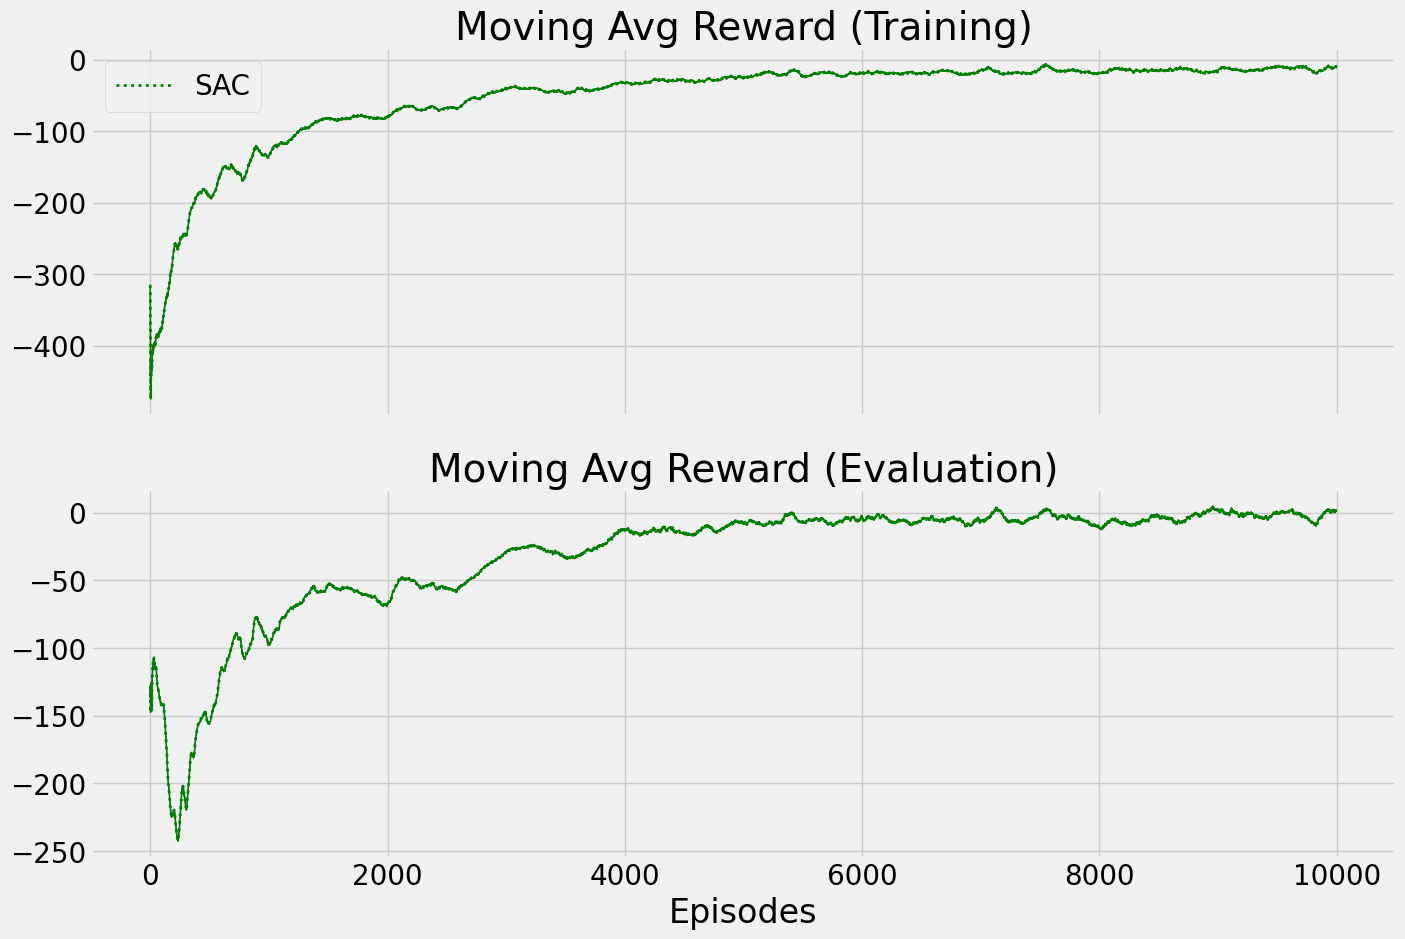

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_r, 'g', linewidth=1)
axs[0].plot(sac_min_r, 'g', linewidth=1)
axs[0].plot(sac_mean_r, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_r, sac_max_r, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_s, 'g', linewidth=1)
axs[1].plot(sac_min_s, 'g', linewidth=1)
axs[1].plot(sac_mean_s, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_s, sac_max_s, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [21]:
torch.save(best_agent.policy_model.state_dict(), "sac_best_policy.pth")

In [ ]:
state = np.array([10,16.92,16.27,16.00,15.95,16.09,16.25,16.76,17.59,17.82,17.97,18.00,17.63, 0.4], dtype=np.float32)

with torch.no_grad():
    action = best_agent.policy_model.select_greedy_action(state)
state[-1]+action.cumsum()

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.32915905,
       0.23239255, 0.28635812], dtype=float32)

In [16]:
def compute_futures_curve(day, S_t, r_t, delta_t):
    futures_list = np.full((N_simulations,12), 0.0, dtype=np.float32)  # Initialize all values as 0.0
    remaining_futures = max(12 - (day // 30), 0)  # Shrinks every 30 days
    for k in range(12):
        expiration_day = (k+1) * 30  # Expiration at the end of month (1-based index)
        tau = (expiration_day - day) / 360.0
        if tau < 0:  # Contract expired, skip (remains 0.0)
            continue
        beta_r = (2 * (1 - np.exp(-ksi_r * tau))) / (2 * ksi_r - (ksi_r - kappa_r) * (1 - np.exp(-ksi_r * tau)))
        beta_delta = -(1 - np.exp(-kappa_delta * tau)) / kappa_delta
        beta_0 = (theta_r / sigma_r**2) * (2 * np.log(1 - (ksi_r - kappa_r) * (1 - np.exp(-ksi_r * tau)) / (2 * ksi_r))
                                                     + (ksi_r - kappa_r) * tau) \
                 + (sigma_delta**2 * tau) / (2 * kappa_delta**2) \
                 - (sigma_s * sigma_delta * rho_1 + theta_delta) * tau / kappa_delta \
                 - (sigma_s * sigma_delta * rho_1 + theta_delta) * np.exp(-kappa_delta * tau) / kappa_delta**2 \
                 + (4 * sigma_delta**2 * np.exp(-kappa_delta * tau) - sigma_delta**2 * np.exp(-2 * kappa_delta * tau)) / (4 * kappa_delta**3) \
                 + (sigma_s * sigma_delta * rho_1 + theta_delta) / kappa_delta**2 \
                 - 3 * sigma_delta**2 / (4 * kappa_delta**3)
        F_tk = np.exp(np.log(S_t) + seasonal_factors[k] + beta_0 + beta_r * r_t + beta_delta * delta_t)
        futures_list[:,k] = F_tk
    return futures_list

In [17]:
# Parameters for the Yan (2002) model
N_simulations = 100 # Number of simulations
T = 360  
dt = 1/(T+1)
# Model Parameters (Assumed)
kappa_r = 0.492828372105622
sigma_r = 0.655898616135014
theta_r = 0.000588276156660185
kappa_delta= 1.17723166341479
sigma_delta = 1.03663918307669
theta_delta = -0.213183673388138
sigma_s = 0.791065501973918
rho_1 = 0.899944474373156
rho_2 = -0.306810849087325
sigma_v = 0.825941396204049
theta_v = 0.0505685591761352
theta = 0.00640705687096142
kappa_v = 2.36309244973169
lam = 0.638842070975342
sigma_j = 0.032046147726045
mu_j = 0.0137146728855484
seed = 34
initial_spot_price = np.exp(2.9479)
initial_r = 0.15958620269619
initial_delta =  0.106417288572204
initial_v =  0.0249967313173077

ksi_r = np.sqrt(kappa_r**2 + 2*sigma_r**2)
seasonal_factors = np.array([ -0.106616824924423, -0.152361004102492, -0.167724706188117, -0.16797984045645,
                             -0.159526180248348, -0.13927943487493, -0.0953402986114613, -0.0474646801238288,
                             -0.0278622280543003, 0.000000, -0.00850263509128089, -0.0409638719325969  ])


# Simulate state variables using Euler-Maruyama
S_t = np.zeros((N_simulations, T+1))
r_t = np.zeros((N_simulations, T+1))
delta_t = np.zeros((N_simulations, T+1))
v_t = np.zeros((N_simulations, T+1))
F_t = np.zeros((N_simulations, T+1, 12))

# Initialize state variables
S_t[:, 0] = initial_spot_price
r_t[:, 0] = initial_r
delta_t[:, 0] = initial_delta
v_t[:, 0] = initial_v
F_t[:,0,:] = compute_futures_curve(0, S_t[:, 0], r_t[:, 0], delta_t[:, 0])
# F_t[:,0,:] = np.tile(np.array([16.92, 16.27, 16.00, 15.95, 16.09, 16.25, 16.76, 17.59, 17.82, 17.97, 18.00, 17.63]), (N_simulations, 1))

W = np.random.default_rng(seed=seed)
# Simulating process

for t in range(1, T+1):
    dW_1 = W.normal(0, np.sqrt(dt), N_simulations)  # For dW_1
    dW_r = W.normal(0, np.sqrt(dt), N_simulations)  # For dW_r (interest rate)
    dW_2 = W.normal(0, np.sqrt(dt), N_simulations)  # For dW_2
    dW_delta = rho_1 * dW_1 + np.sqrt(1 - rho_1 ** 2) * W.normal(0, np.sqrt(dt), N_simulations)  # For dW_delta (correlated with dW_1)
    dW_v = rho_2 * dW_2 + np.sqrt(1 - rho_2 ** 2) * W.normal(0, np.sqrt(dt), N_simulations)  # For dW_v (correlated with dW_2)
    
    # Probability of jump occurrence
    dq = W.choice([0, 1], p=[1 - lam * dt, lam * dt], size = N_simulations)

    # Jump magnitude: ln(1 + J) ~ N[ln(1 + mu_J) - 0.5 * sigma_J^2, sigma_J^2]
    ln_1_plus_J = W.normal(np.log(1 + mu_j) - 0.5 * sigma_j ** 2, sigma_j, N_simulations)
    J = np.exp(ln_1_plus_J) - 1  # Jump size for the spot price

    J_v = W.exponential(scale=theta, size = N_simulations)

    S_t[:, t] = S_t[:, t-1] + (r_t[:, t-1] - delta_t[:, t-1] - lam * mu_j) * S_t[:, t-1] * dt + sigma_s * S_t[:, t-1] * dW_1 + np.sqrt(np.maximum(v_t[:, t-1],0)) * S_t[:, t-1] * dW_2 + J * S_t[:, t-1] * dq

    r_t[:, t] = r_t[:, t-1] + (theta_r - kappa_r * r_t[:, t-1]) * dt + sigma_r * np.sqrt(np.maximum(r_t[:, t-1], 0)) * dW_r

    delta_t[:, t] = delta_t[:, t-1] + (theta_delta - kappa_delta * delta_t[:, t-1]) * dt + sigma_delta * dW_delta

    v_t[:, t] = v_t[:, t-1] + (theta_v - kappa_v * v_t[:, t-1]) * dt + sigma_v * np.sqrt(np.maximum(v_t[:, t-1], 0)) * dW_v + J_v * dq

    F_t[:, t, :] = compute_futures_curve(t, S_t[:, t], r_t[:, t], delta_t[:, t] )

In [18]:
from scipy.optimize import linprog
N_simulations = 100  # Number of simulations
n = 12  # Number of months
T = 360  
N_maturities = 12
decision_times = np.arange(0, T+1, 30)  # Decision points tau = [0, 30, 60, ..., 360]
V_max = 1.0
V_min = 0.0
I_max = 0.4
W_max = 0.4
V_0 = 0  # Initial reservoir balance
V_T = 0  # Final balance condition

# Initialize results
V_I_Rolling = np.zeros((N_simulations, len(decision_times)))  # Intrinsic value per maturity
CF_IE_Rolling = np.zeros(N_simulations)  # Total cash-flow per simulation
X_tau = np.zeros((N_simulations, len(decision_times), N_maturities))

# Loop over all simulations
for j in range(N_simulations):
    V_t = V_0
    L_n = np.tril(np.ones((n, n)))  # Lower triangular matrix for cumulative sums
    A = np.vstack([L_n, -L_n])  # Stacking for V_max and V_min constraints
    b = np.hstack([(V_max - V_t) * np.ones(n), -(V_min - V_t) * np.ones(n)])
    # Equality constraint: Final balance VT = 0
    A_eq = np.ones((1, n))
    b_eq = np.array([V_T - V_t])
    # Box constraints: -W_max ≤ xi ≤ I_max
    bounds = [(-W_max, I_max) for _ in range(n)]
    CF = 0
    for i, tau in enumerate(decision_times):
        if i == 0:
            # Compute initial intrinsic value V_I,0 = -F_0 * X_0 for all maturities
            prices = F_t[j, tau, :]
            X_tau[j, i, :] = linprog(prices, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds,  method="highs").x 
            V_I_Rolling[j, i] = -np.dot(prices , X_tau[j, i, :])
            continue
            
        prev_tau = decision_times[i-1]
        
        # Compute realized P/L from futures position for each maturity
        CF += np.dot((F_t[j, tau, :] - F_t[j, prev_tau, :]) , X_tau[j, i-1, :])

        # Update intrinsic value for each maturity
        prices = F_t[j, tau, :]
        # Identify zero-price variables
        zero_price_indices = (prices == 0)
        # Modify bounds: Force zero-price variables to be zero (fix them)
        adjusted_bounds = [(0, 0) if zero_price_indices[i] else bounds[i] for i in range(len(prices))]
        
        if i < 12:
            X_tau[j, i, :] = linprog(prices, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=adjusted_bounds, method="highs").x 
        else:
            X_tau[j, i, :] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -V_t])
            CF += -F_t[j, tau, i-1] * X_tau[j, i, i-1]

        V_I_Rolling[j, i] = -np.dot(prices , X_tau[j, i, :])
        
        V_t += X_tau[j, i, i-1]
        b = np.hstack([(V_max - V_t) * np.ones(n), -(V_min - V_t) * np.ones(n)])
        b_eq = np.array([V_T - V_t])

        # Compute spot cash-flow using front-month futures (maturity=0)
        # CF += -F_t[j, tau, i-1] * X_tau[j, i, i-1]
            
    # Update total cash-flows for this simulation
    CF_IE_Rolling[j] = CF

# Compute estimated total intrinsic + extrinsic value
V_IE_Rolling = np.mean(CF_IE_Rolling)

# Display results
print(f"Estimated Rolling Intrinsic + Extrinsic Value: {V_IE_Rolling:.4f}")

Estimated Rolling Intrinsic + Extrinsic Value: 3.8301


In [19]:
N_simulations = 100 # Number of simulations
T = 360  
N_maturities = 12
decision_times = np.arange(0, T+1, 30)  # Decision points tau = [0, 30, 60, ..., 360]
V_max = 1.0
V_min = 0.0
I_max = 0.4
W_max = 0.4
V_0 = 0  # Initial reservoir balance
V_T = 0  # Final balance condition

# Initialize results
V_I = np.zeros((N_simulations, len(decision_times)))  # Intrinsic value per maturity
CF_IE = np.zeros(N_simulations)  # Total cash-flow per simulation
X_tau = np.zeros((N_simulations, len(decision_times), N_maturities))

# Loop over all simulations
for j in range(N_simulations):
    V_t = V_0
    # L_n = np.tril(np.ones((n, n)))  # Lower triangular matrix for cumulative sums
    # A = np.vstack([L_n, -L_n])  # Stacking for V_max and V_min constraints
    # b = np.hstack([(V_max - V_t) * np.ones(n), -(V_min - V_t) * np.ones(n)])
    # # Equality constraint: Final balance VT = 0
    # A_eq = np.ones((1, n))
    # b_eq = np.array([V_T - V_t])
    # # Box constraints: -W_max ≤ xi ≤ I_max
    # bounds = [(-W_max, I_max) for _ in range(n)]
    CF = 0
    for i, tau in enumerate(decision_times):
        if i == 0:
            # Compute initial intrinsic value V_I,0 = -F_0 * X_0 for all maturities
            prices = F_t[j, tau, :]
            state = np.concatenate((np.array([i]),prices,np.array([V_t])),dtype=np.float32)
            # env.month = state[0]
            # env.V_t = state[-1]
            X_tau[j, i, :] = best_agent.policy_model.select_greedy_action(state)
            # X_tau[j, i, -1] = np.clip(-X_tau[j, i, :-1].cumsum()[-1]-V_t,-W_max, I_max)
            X_tau[j, i, :] = np.round(X_tau[j, i, :],2)
            # X_tau[j, i, :] = trained_network(state).detach().cpu().numpy()
            V_I[j, i] = -np.dot(prices , X_tau[j, i, :])
            continue
            
        prev_tau = decision_times[i-1]
        # Compute realized P/L from futures position for each maturity
        CF += np.dot((F_t[j, tau, :] - F_t[j, prev_tau, :]) , X_tau[j, i-1, :])

        # Update intrinsic value for each maturity
        prices = F_t[j, tau, :]
        state = np.concatenate((np.array([i]),prices,np.array([V_t])),dtype=np.float32)
        # env.month = state[0]
        # env.V_t = state[-1]
        X_tau[j, i, :] = best_agent.policy_model.select_greedy_action(state)
        # X_tau[j, i, -1] = np.clip(-X_tau[j, i, :-1].cumsum()[-1]-V_t,-W_max, I_max)
        X_tau[j, i, :] = np.round(X_tau[j, i, :],2)
        # if i < 12:
        #     X_tau[j, i, :] = env.rescale_actions(agent.evaluation_strategy.select_action(agent.online_policy_model, state))
        #     # X_tau[j, i, :] = trained_network(state).detach().cpu().numpy()
        # else:
        #     X_tau[j, i, :] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.clip(-V_t,-W_max,I_max)])
        if i == 12:           
            X_tau[j, i, :] = np.zeros(12,dtype=np.float32)
            X_tau[j, i, -1] = X_tau[j, i-1, -1]
            X_tau[j, i, :] = np.round(X_tau[j, i, :],2)
            # print("X_tau[j, i]:  ",np.round(X_tau[j, i],2))
            CF += -F_t[j, tau, i-1] * X_tau[j, i-1, i-1] 
            V_I[j, i] = -np.dot(prices , X_tau[j, i, :])

        V_I[j, i] = -np.dot(prices , X_tau[j, i, :])
        
        V_t += np.round(X_tau[j, i, i-1],2)
        # b = np.hstack([(V_max - V_t) * np.ones(n), -(V_min - V_t) * np.ones(n)])
        # b_eq = np.array([V_T - V_t])

        # Compute spot cash-flow using front-month futures (maturity=0)
        # CF += -F_t[j, tau, i-1] * X_tau[j, i, i-1]
            
    # Update total cash-flows for this simulation
    CF_IE[j] = CF

# Compute estimated total intrinsic + extrinsic value
V_IE = np.mean(CF_IE)

# Display results
print(f"Estimated Rolling Intrinsic + Extrinsic Value: {V_IE:.4f}")

Estimated Rolling Intrinsic + Extrinsic Value: 4.3677


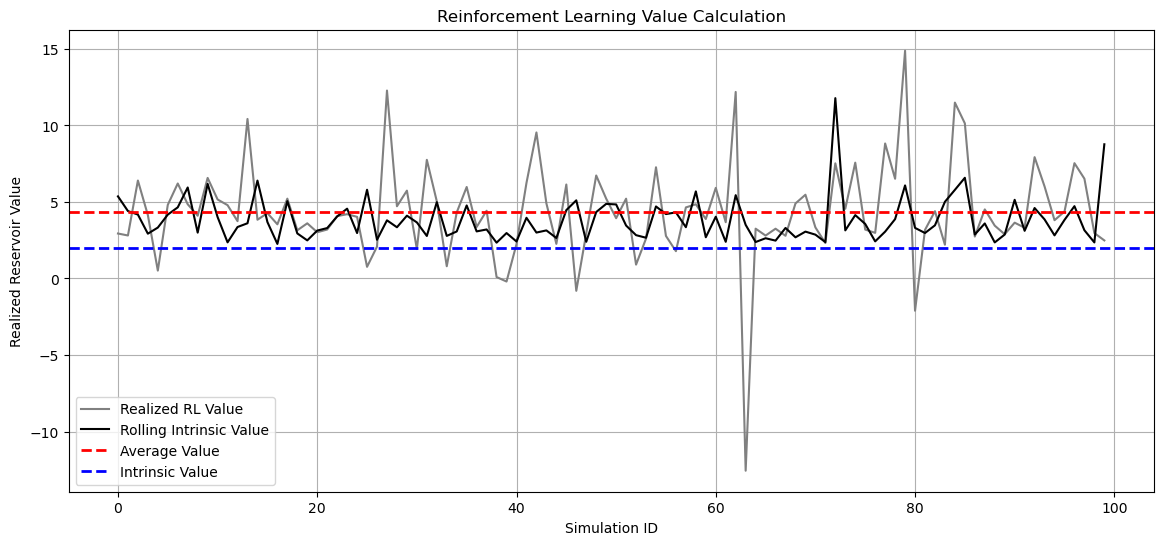

In [20]:
plt.style.use('default')  # Reset to classic white background style 
plt.figure(figsize=(14, 6))
plt.plot(CF_IE, color='grey', label="Realized RL Value")
plt.plot(CF_IE_Rolling, color='black', label="Rolling Intrinsic Value")
plt.axhline(V_IE, color='red', linestyle='--', linewidth=2, label="Average Value")
plt.axhline(1.962, color='blue', linestyle='--', linewidth=2, label="Intrinsic Value")
plt.xlabel("Simulation ID")
plt.ylabel("Realized Reservoir Value")
plt.title("Reinforcement Learning Value Calculation")
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig("Reinforcement_Learning_Value.png")

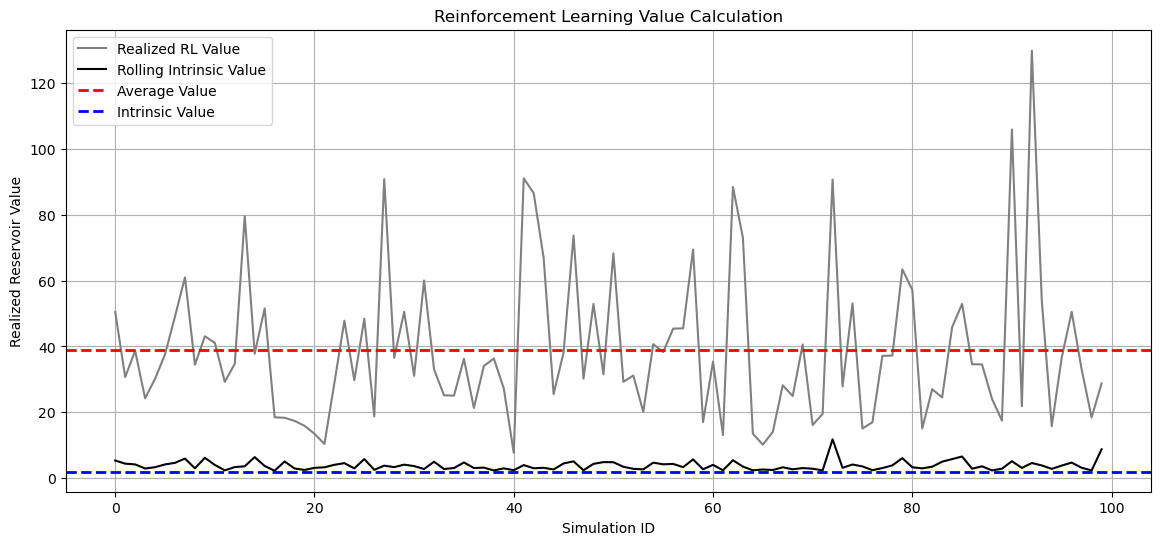